       Dates  Close   Open   High    Low
0 2010-04-13  84.05  84.36  84.42  82.51
1 2010-04-14  85.84  83.82  86.39  83.71
2 2010-04-15  85.51  85.91  86.27  85.27
3 2010-04-16  83.24  85.31  85.44  82.52
4 2010-04-19  81.45  82.90  83.00  80.53


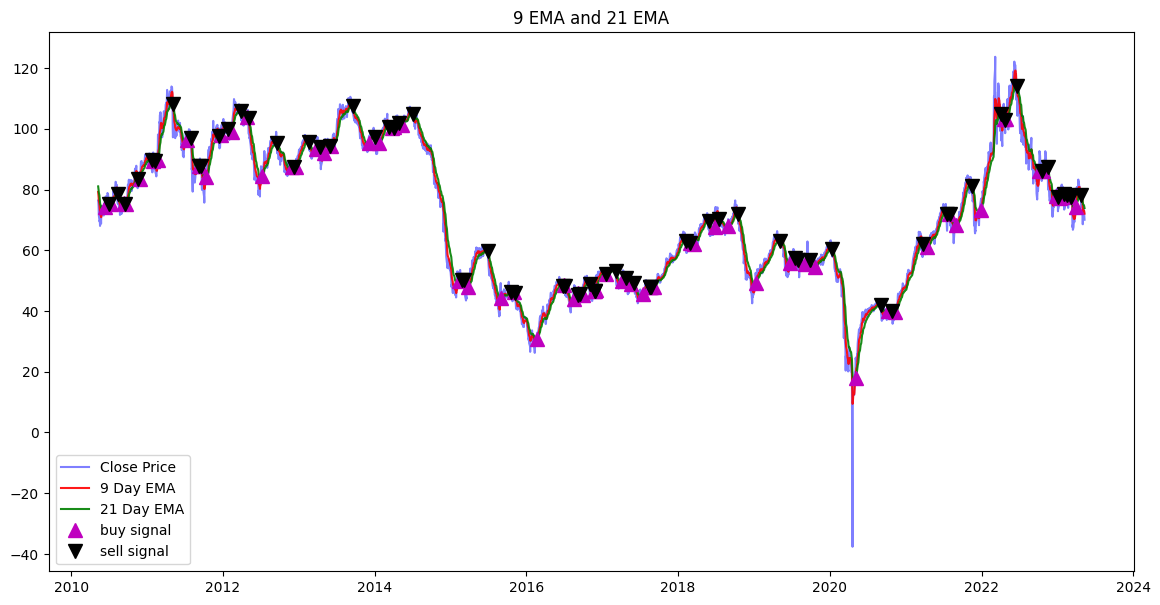

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
# Define the file path (change this to your actual file path)

def find(name, path):
    for root, dirs, files in os.walk(path):
        if name in files:
            return os.path.join(root, name)

# Load the data from the Excel file
x = find('bb_crude_data.xlsx', os.getcwd())
data = pd.read_excel(x)
original_data = pd.read_excel(x)

# Display the first few rows of the data
print(data.head())
# Define functions for SMA and EMA
def SMA(data, ndays): 
    data["{0}SMA".format(ndays)] = data['Close'].rolling(ndays).mean()
    return data

def EMA(data,ndays):
    data["{0}EMA".format(ndays)] = data['Close'].ewm(span = ndays, min_periods = ndays - 1).mean()
    return data

# Core logic for generating buy and sell signals
'''
 signal: if 9EMA is greater than 21EMA, set signal to "1". if 9EMA is less than 21EMA, set signal to "0". This signal is 1 signal a day, determined by the closing price of crude oil, for both the 9 day exponential moving average and
 the 21 day exponential moving average. 
 
 position: position strictly acts on data in the "signal" column. position works by taking the current signal, and subtracting it from the previous signal. for example, if signal at current day is "0" and signal at current day - 1
 is "0", then no position is acted upon. If the signal at the current day is "1" and the previous day is "0", then enter a position. If the signal is 0 at the current day, and 1 at the previous day, exit your position.
'''
def core_logic(data=pd.DataFrame()): 
    data = data.set_index('Dates')
    data = data[data.index > '2010-05-10'] 
    data['Signal'] = np.where(data['9EMA'] > data['21EMA'], 1, 0)
    data['Position'] = data['Signal'].diff()
    return data

# Create EMA columns
data = EMA(data, 9)
data = EMA(data, 21)

# Create buy / sell signals
data = core_logic(data=data)

# Initialize the new columns
data['Cash Position'] = 0.0
data['Portfolio Value'] = 0.0
data['PnL'] = 0.0

cash_position = 25000.0
portfolio_value = 0.0
pnl = 0.0
buy_price = 0.0

for i, row in data.iterrows():
    if row['Position'] == 1:
        cash_position -= row['Close']
        portfolio_value = row['Close']
        buy_price = row['Close']  # store the buy price
    elif row['Position'] == -1:
        cash_position += row['Close']
        pnl += row['Close'] - buy_price  # calculate the PnL
        portfolio_value = 0.0
    else:
        if portfolio_value > 0:  # we have an open position
            portfolio_value = row['Close']  # update portfolio value at current day's closing price

    data.at[i, 'Cash Position'] = cash_position
    data.at[i, 'Portfolio Value'] = portfolio_value
    data.at[i, 'PnL'] = pnl

plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='Close Price', color='blue', alpha=0.5)
plt.plot(data.index, data['9EMA'], label='9 Day EMA', color='red', alpha=0.9)
plt.plot(data.index, data['21EMA'], label='21 Day EMA', color='green', alpha=0.9)
plt.plot(data[data['Position'] == 1].index, data['9EMA'][data['Position'] == 1], '^', markersize=10, color='m', label='buy signal')
plt.plot(data[data['Position'] == -1].index, data['21EMA'][data['Position'] == -1], 'v', markersize=10, color='k', label='sell signal')
plt.title('9 EMA and 21 EMA')
plt.legend()
plt.show()

data.to_csv('trading-output-test.csv')




In [11]:
import requests 
def request_url(url):
    try:
        response = requests.get(url)
        response.raise_for_status()

    except requests.exceptions.HTTPError as errh:
        print ("HTTP Error:",errh)
    except requests.exceptions.ConnectionError as errc:
        print ("Error Connecting:",errc)
    except requests.exceptions.Timeout as errt:
        print ("Timeout Error:",errt)
    except requests.exceptions.RequestException as err:
        print ("Something went wrong",err)

    else:
        return response
